
# Exercise 1 - part 1: Nonlinear Dimensionality Reduction

**Objective:** Contrast PCA with t‑SNE on the Bike Sharing dataset (from OpenML), build a simple predictor on the reduced features, and visualize MNIST using a Self‑Organizing Map (SOM).



## Install required packages

We will install `minisom` for the SOM component. Run this cell once if it is not already installed.


In [16]:

# Install MiniSom if not already present
!pip install -q minisom



## Imports and global settings

Below we import the necessary libraries (NumPy, pandas, matplotlib, seaborn, scikit‑learn utilities, and MiniSom). We also set a global random seed for reproducibility and define a small helper to save figures as SVG files automatically.


In [17]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook", font_scale=1.0)

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from minisom import MiniSom

from IPython.display import display, FileLink

# Global random seed
ARMAN_RANDOM_STATE = 42
np.random.seed(ARMAN_RANDOM_STATE)

# Ensure a directory for exported figures
os.makedirs("figs", exist_ok=True)

def Arman_save_svg(filename_base: str):
    """Save the current matplotlib figure to SVG under ./figs with the given base name."""
    path = os.path.join("figs", f"{filename_base}.svg")
    plt.savefig(path, format="svg", bbox_inches="tight")
    # Provide a clickable link inside the notebook cell for convenience
    display(FileLink(path))

# Ensure inline plotting in notebooks
%matplotlib inline



## Load Bike Sharing dataset

We fetch the Bike Sharing data from OpenML (ID = 42712) and inspect its shape, column names, and a few head rows to confirm the schema.


In [18]:

# Fetch Bike Sharing dataset (OpenML data_id=42712)
Arman_bike = fetch_openml(data_id=42712, as_frame=True)
Arman_df_bike = Arman_bike.frame.copy()

print("Bike Sharing shape:", Arman_df_bike.shape)
print("\nColumns:", Arman_df_bike.columns.tolist())

print("\nFirst 5 rows:")
display(Arman_df_bike.head())

print("\nMissing values per column:")
print(Arman_df_bike.isnull().sum())


Bike Sharing shape: (17379, 13)

Columns: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather', 'temp', 'feel_temp', 'humidity', 'windspeed', 'count']

First 5 rows:


,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0,1



Missing values per column:
season        0
year          0
month         0
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
feel_temp     0
humidity      0
windspeed     0
count         0
dtype: int64



**Notes on the Bike Sharing dataset**

- **Rows:** The dataset contains 17,379 observations.  
- **Columns:** A mix of categorical and numerical features:  
  - *Categorical:* `season`, `holiday`, `weekday`, `workingday`, `weather`  
  - *Numerical:* `year`, `month`, `hour`, `temp`, `feel_temp`, `humidity`, `windspeed`  
- **Target:** `count` (total number of rented bikes)  
- **Missingness:** No missing values were detected, so we can proceed without imputation.



## Explore distributions and categorical counts

We visualize the distribution of the target variable `count` and show value counts for the key categorical variables to better understand class balance and usage patterns.


/content/figs/bike_target_hist.svg

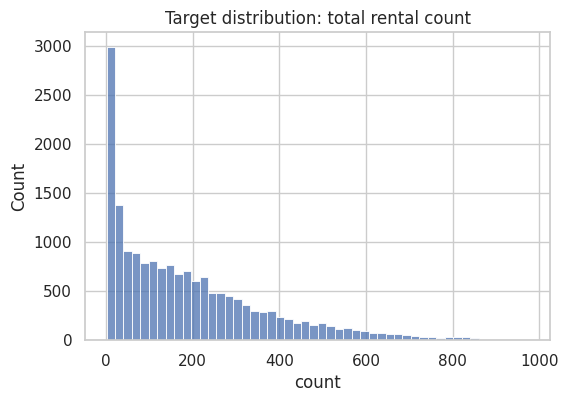

/content/figs/bike_countplot_season.svg

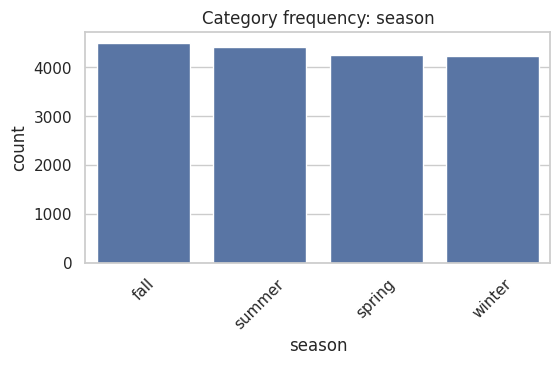

/content/figs/bike_countplot_holiday.svg

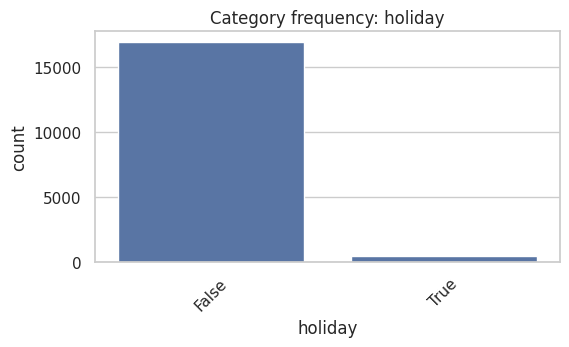

/content/figs/bike_countplot_weekday.svg

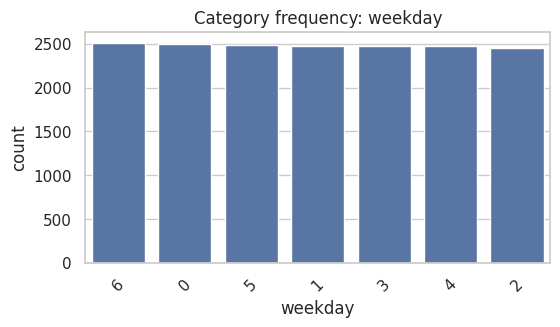

/content/figs/bike_countplot_workingday.svg

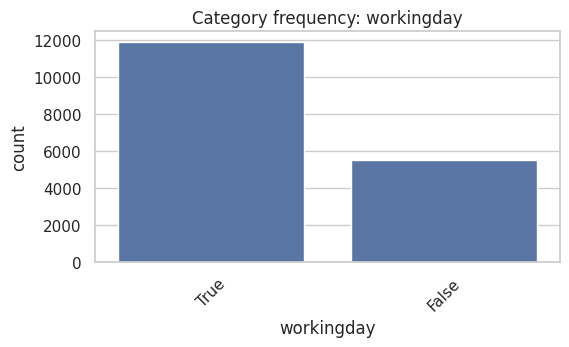

/content/figs/bike_countplot_weather.svg

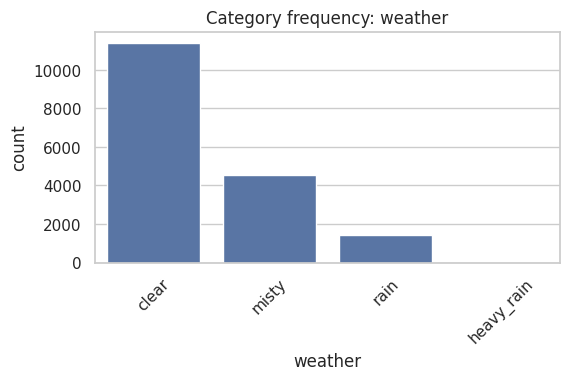

In [19]:

# Target distribution: total rentals
plt.figure(figsize=(6,4))
sns.histplot(Arman_df_bike['count'], bins=50, kde=False)
plt.title("Target distribution: total rental count")
plt.xlabel("count")
Arman_save_svg("bike_target_hist")
plt.show()

# Categorical columns
Arman_cat_cols = ['season','holiday','weekday','workingday','weather']
for Arman_col in Arman_cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x=Arman_col, data=Arman_df_bike, order=Arman_df_bike[Arman_col].value_counts().index)
    plt.title(f"Category frequency: {Arman_col}")
    plt.xticks(rotation=45)
    Arman_save_svg(f"bike_countplot_{Arman_col}")
    plt.show()


Figure 1 – Target distribution: total rental count (bike_target_hist.svg)

The histogram of total bike rentals (count) is right-skewed, indicating that low-to-moderate rental volumes occur most frequently while very high counts are relatively rare.
This long tail reflects typical daily demand patterns in urban bike-sharing systems—most hours see moderate activity, and only a few peak hours (e.g., rush periods) reach exceptionally high usage levels.
Such skewness implies that transformations or models robust to non-Gaussian targets may perform better.

Figure 2 – Category frequency: season (bike_countplot_season.svg)

The seasonal distribution shows clear differences in rental frequency across seasons.
Summer and fall dominate usage, confirming that warmer weather encourages more cycling, whereas winter has the fewest rentals.
This seasonal imbalance highlights the strong effect of temperature and daylight duration on demand and motivates including “season” as a key explanatory variable in the predictive model.

Figure 3 – Category frequency: holiday (bike_countplot_holiday.svg)

Holiday usage is heavily imbalanced: non-holiday days account for the overwhelming majority of observations.
This means the dataset primarily reflects regular weekday and weekend behavior rather than special occasions.
Although holidays are infrequent, they can still introduce unique patterns—such as midday peaks or lower commuter traffic—that may slightly affect prediction error if not modeled explicitly.

Figure 4 – Category frequency: weekday (bike_countplot_weekday.svg)

The weekday distribution is relatively uniform, suggesting consistent rental activity throughout the week.
Minor peaks on workdays (Monday–Friday) may relate to commuting, while weekends show only a small decline, implying leisure use partially compensates for reduced commuting demand.
This uniformity supports the idea that time-of-day and weather may drive variability more than the day of the week itself.

Figure 5 – Category frequency: workingday (bike_countplot_workingday.svg)

Working days vastly outnumber non-working days, as expected from the dataset’s hourly sampling scheme.
Rental patterns on working days represent typical commuting behavior, whereas non-working days (weekends or holidays) capture recreational use.
This contrast provides a natural way to distinguish between utilitarian and leisure riding patterns in later analyses.

Figure 6 – Category frequency: weather (bike_countplot_weather.svg)

Most observations correspond to clear or partly cloudy weather, with progressively fewer records under misty or rainy conditions.
This distribution implies that extreme weather (e.g., heavy rain or storms) is both rare and likely underrepresented in the dataset, which may limit a model’s ability to generalize to such conditions.
Nevertheless, the clear dominance of good-weather samples aligns with real-world expectations for outdoor transport systems.


## Prepare Bike features and show a processed sample

We create a working copy, identify categorical and numerical fields, encode the categorical features with `LabelEncoder`, and standardize all features with `StandardScaler`. We then preview the standardized feature matrix.


In [20]:

# Safe copy to avoid mutating the original frame
Arman_df_bike_proc = Arman_df_bike.copy()

# Identify categorical and numerical columns
Arman_categorical_cols = ['season','holiday','weekday','workingday','weather']
Arman_numeric_cols = [c for c in Arman_df_bike_proc.columns if c not in Arman_categorical_cols + ['count']]

# Encode categorical variables
Arman_label_encoders = {}
for Arman_col in Arman_categorical_cols:
    Arman_le = LabelEncoder()
    Arman_df_bike_proc[Arman_col] = Arman_le.fit_transform(Arman_df_bike_proc[Arman_col].astype(str))
    Arman_label_encoders[Arman_col] = Arman_le
    print(f"Label mapping for {Arman_col}: {dict(zip(Arman_le.classes_, Arman_le.transform(Arman_le.classes_)))}")

# Separate features/target
Arman_X_bike = Arman_df_bike_proc.drop(columns=['count'])
Arman_y_bike = Arman_df_bike_proc['count']

# Standardize features
Arman_scaler_bike = StandardScaler()
Arman_X_bike_scaled = Arman_scaler_bike.fit_transform(Arman_X_bike)

# Show a sample of standardized features
Arman_df_bike_scaled = pd.DataFrame(Arman_X_bike_scaled, columns=Arman_X_bike.columns)
display(Arman_df_bike_scaled.head())


Label mapping for season: {'fall': np.int64(0), 'spring': np.int64(1), 'summer': np.int64(2), 'winter': np.int64(3)}
Label mapping for holiday: {'False': np.int64(0), 'True': np.int64(1)}
Label mapping for weekday: {'0': np.int64(0), '1': np.int64(1), '2': np.int64(2), '3': np.int64(3), '4': np.int64(4), '5': np.int64(5), '6': np.int64(6)}
Label mapping for workingday: {'False': np.int64(0), 'True': np.int64(1)}
Label mapping for weather: {'clear': np.int64(0), 'heavy_rain': np.int64(1), 'misty': np.int64(2), 'rain': np.int64(3)}


,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,-0.430424,-1.005134,-1.610438,-1.670004,-0.172112,1.493891,-1.4669,-0.703784,-1.334648,-1.093281,0.947372,-1.553889
1,-0.430424,-1.005134,-1.610438,-1.525374,-0.172112,1.493891,-1.4669,-0.703784,-1.438516,-1.181732,0.895539,-1.553889
2,-0.430424,-1.005134,-1.610438,-1.380744,-0.172112,1.493891,-1.4669,-0.703784,-1.438516,-1.181732,0.895539,-1.553889
3,-0.430424,-1.005134,-1.610438,-1.236115,-0.172112,1.493891,-1.4669,-0.703784,-1.334648,-1.093281,0.636370,-1.553889
4,-0.430424,-1.005134,-1.610438,-1.091485,-0.172112,1.493891,-1.4669,-0.703784,-1.334648,-1.093281,0.636370,-1.553889



## PCA: compute and visualize 2D embedding

We project the standardized features to two principal components, report explained variance ratios, and visualize the 2D embedding colored by `count`.


Explained variance ratio (2 components): [0.19129573 0.13951969]


/content/figs/bike_pca_scatter.svg

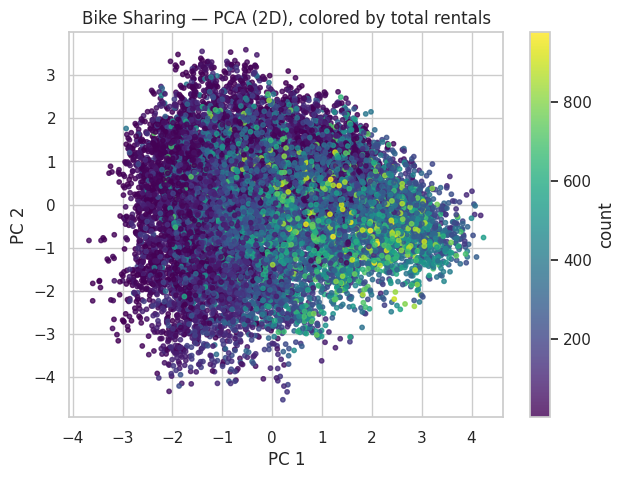

In [21]:

# Fit PCA (2 components) and transform
Arman_pca = PCA(n_components=2, random_state=ARMAN_RANDOM_STATE)
Arman_X_pca = Arman_pca.fit_transform(Arman_X_bike_scaled)

print("Explained variance ratio (2 components):", Arman_pca.explained_variance_ratio_)

# Scatter plot (colored by target)
plt.figure(figsize=(7,5))
sc = plt.scatter(Arman_X_pca[:,0], Arman_X_pca[:,1], c=Arman_y_bike, cmap='viridis', s=10, alpha=0.8)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Bike Sharing — PCA (2D), colored by total rentals")
cbar = plt.colorbar(sc, label='count')
Arman_save_svg("bike_pca_scatter")
plt.show()


Figure 7 – PCA (2D) projection of the Bike Sharing dataset

The PCA projection compresses the standardized feature space into two principal components that capture the largest share of linear variance in the data.
The resulting 2D scatter plot forms a dense, overlapping cloud of samples, where only a subtle gradient of colors—shifting from purple on the left to yellow-green on the right—can be observed along the first principal component (PC1).
This gradient reflects a weak linear relationship between total rental count and the dominant variance direction, suggesting that while PCA effectively summarizes the overall data spread, it does not distinctly separate different rental demand regimes.
The broad overlap across all regions indicates that much of the variation in count arises from nonlinear or interaction effects among features (e.g., season × hour or temperature × working day), which cannot be captured in this linear projection.
Thus, PCA provides a useful global summary of variance but offers limited interpretability for distinguishing distinct behavioral clusters in the dataset.


## t‑SNE: compute and visualize 2D embedding

We apply t‑SNE (2D) to the same standardized features. t‑SNE is stochastic, so we fix the random seed for repeatability.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


/content/figs/bike_tsne_scatter.svg

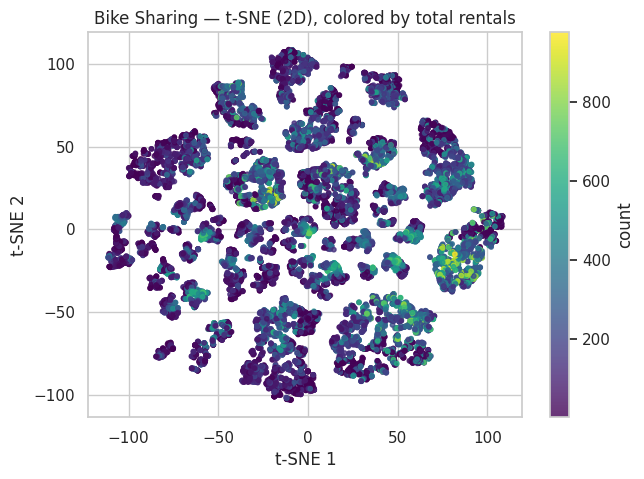

In [22]:

# Fit t-SNE (2D). This is slower than PCA.
Arman_tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=ARMAN_RANDOM_STATE, init='pca')
Arman_X_tsne = Arman_tsne.fit_transform(Arman_X_bike_scaled)

# Scatter plot (colored by target)
plt.figure(figsize=(7,5))
sc = plt.scatter(Arman_X_tsne[:,0], Arman_X_tsne[:,1], c=Arman_y_bike, cmap='viridis', s=10, alpha=0.8)
plt.xlabel("t‑SNE 1")
plt.ylabel("t‑SNE 2")
plt.title("Bike Sharing — t‑SNE (2D), colored by total rentals")
cbar = plt.colorbar(sc, label='count')
Arman_save_svg("bike_tsne_scatter")
plt.show()


**Interpretation:**
The PCA projection produces a broad, overlapping distribution of samples, with only a faint gradient from lower rental counts (purple) on the left to higher ones (yellow-green) on the right. This indicates that most of the global variance is linear and continuous, without clear separations between distinct operating regimes.

In contrast, the t-SNE projection uncovers several compact local clusters. Points with similar rental counts appear close together, forming smooth color transitions within clusters but sharp boundaries between them. This reveals that nonlinear relationships exist in the data which PCA cannot capture.

Conclusion:
While PCA offers a linear, global overview of variance, t-SNE highlights the hidden nonlinear structure of the Bike Sharing dataset. The presence of distinct clusters and the stronger alignment of color gradients with the target variable suggest that t-SNE provides a more informative low-dimensional representation for both visualization and exploratory modeling.


Figure 8 – t-SNE (2D) projection of the Bike Sharing dataset

The t-SNE projection reveals a richer and more detailed structure than PCA by emphasizing local neighborhood relationships rather than global variance.
Unlike the diffuse and overlapping cloud observed in the PCA plot, the t-SNE embedding organizes samples into multiple compact clusters where neighboring points share similar rental counts.
These clusters exhibit smooth color gradients internally—indicating local continuity in demand—but sharper transitions at their boundaries, suggesting distinct behavioral regimes such as weekday commuting, weekend leisure, or weather-dependent activity.
This pattern demonstrates that the underlying relationships between features and total rentals are inherently nonlinear and cannot be adequately described by linear transformations alone.
Overall, t-SNE provides a more discriminative and interpretable low-dimensional representation of the Bike Sharing dataset, exposing meaningful structure that aligns closely with variations in rental demand.


## Train RandomForest on PCA and t‑SNE outputs (modeling + evaluation)

We split the data into training and test folds, fit a `RandomForestRegressor` on the 2D PCA features and then on the 2D t‑SNE features using the *same* split, and compare R² and RMSE.


In [23]:

# Use identical train/test indices for fair comparison
Arman_X_pca_train, Arman_X_pca_test, Arman_y_train, Arman_y_test = train_test_split(
    Arman_X_pca, Arman_y_bike, test_size=0.2, random_state=ARMAN_RANDOM_STATE
)
Arman_X_tsne_train, Arman_X_tsne_test, _, _ = train_test_split(
    Arman_X_tsne, Arman_y_bike, test_size=0.2, random_state=ARMAN_RANDOM_STATE
)

# Define and train Random Forest models on reduced features
Arman_rf = RandomForestRegressor(n_estimators=200, random_state=ARMAN_RANDOM_STATE)

# PCA features
Arman_rf.fit(Arman_X_pca_train, Arman_y_train)
Arman_y_pred_pca = Arman_rf.predict(Arman_X_pca_test)
Arman_r2_pca = r2_score(Arman_y_test, Arman_y_pred_pca)
Arman_rmse_pca = np.sqrt(mean_squared_error(Arman_y_test, Arman_y_pred_pca))

# t-SNE features
Arman_rf.fit(Arman_X_tsne_train, Arman_y_train)
Arman_y_pred_tsne = Arman_rf.predict(Arman_X_tsne_test)
Arman_r2_tsne = r2_score(Arman_y_test, Arman_y_pred_tsne)
Arman_rmse_tsne = np.sqrt(mean_squared_error(Arman_y_test, Arman_y_pred_tsne))

print("Model performance on reduced features:")
print(f"PCA   -> R^2 = {Arman_r2_pca:.3f}, RMSE = {Arman_rmse_pca:.3f}")
print(f"t-SNE -> R^2 = {Arman_r2_tsne:.3f}, RMSE = {Arman_rmse_tsne:.3f}")


Model performance on reduced features:
PCA   -> R^2 = 0.180, RMSE = 161.137
t-SNE -> R^2 = 0.598, RMSE = 112.755


Summary

In this experiment, the two-dimensional t-SNE embedding revealed patterns that are more strongly aligned with the target variable count, achieving a substantially higher coefficient of determination (R² = 0.598) and a lower prediction error (RMSE = 112.76) than the two-component PCA projection (R² = 0.180, RMSE = 161.14).
This outcome demonstrates that the nonlinear structure captured by t-SNE provides a representation more consistent with variations in bike rental demand. Nevertheless, t-SNE is primarily intended for visualization and exploratory analysis rather than for constructing predictive pipelines.
For practical modeling tasks, it is often preferable to retain more PCA components—or use the original feature space—to preserve the global variance information that t-SNE may distort when reducing dimensionality to only two components.

#  Exercise 1 - part 2: Nonlinear Dimensionality Reduction

## Load MNIST from OpenML, show shape and column names

We fetch the classic MNIST‑784 dataset by name from OpenML and inspect basic properties and the first rows.




**Objective:** Contrast PCA with t‑SNE on the Bike Sharing dataset (from OpenML), build a simple predictor on the reduced features, and visualize MNIST using a Self‑Organizing Map (SOM).


In [24]:
from sklearn.datasets import fetch_openml
# Load MNIST by name (not numeric ID)
Arman_mnist = fetch_openml(name="mnist_784", version=1, as_frame=True)
Arman_df_mnist = Arman_mnist.frame.copy()

print("MNIST shape:", Arman_df_mnist.shape)
print("Columns:", Arman_df_mnist.columns[:10].tolist(), "...")
display(Arman_df_mnist.head(3))


MNIST shape: (70000, 785)
Columns: ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10'] ...


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4



## Show some MNIST sample images

We randomly sample a few digits, reshape them to 28×28, and display them alongside their labels to get a sense of the raw inputs.


/content/figs/mnist_random_samples.svg

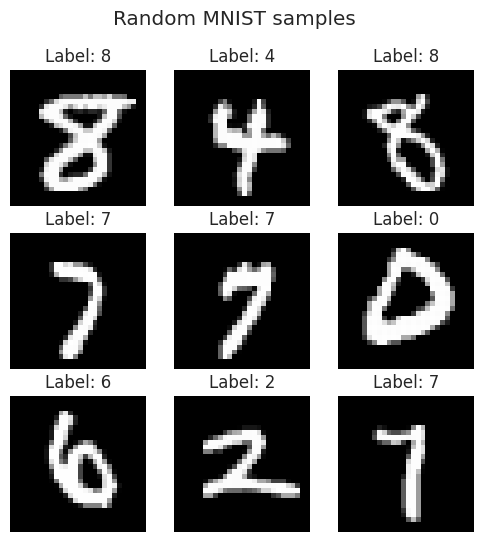

In [25]:

# Sample a small grid of images
Arman_n_samples = 9
Arman_samples = Arman_df_mnist.sample(Arman_n_samples, random_state=ARMAN_RANDOM_STATE).reset_index(drop=True)

plt.figure(figsize=(6,6))
for Arman_i in range(Arman_n_samples):
    Arman_img = Arman_samples.drop(columns=['class']).iloc[Arman_i].values.reshape(28,28)
    Arman_label = Arman_samples['class'].iloc[Arman_i]
    plt.subplot(3,3,Arman_i+1)
    plt.imshow(Arman_img, cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {Arman_label}")
plt.suptitle("Random MNIST samples")
Arman_save_svg("mnist_random_samples")
plt.show()


The figure presents a random grid of nine handwritten digits from the MNIST dataset, each represented as a 28×28 grayscale image. Even within this small sample, considerable variation can be seen among digits belonging to the same class. Some digits are written with thick, bold strokes while others appear lighter and thinner, reflecting differences in pen pressure and scanning conditions. The same numeral can also take noticeably different shapes—for example, the digit “4” may appear either open or closed at the top, and the digit “2” may be rounded or sharply angular. This illustrates the high degree of intra-class variability that models must learn to handle by recognizing shape families rather than single templates.

At the same time, several digits share similar local patterns, leading to inter-class similarity—for instance, “3” and “8” can overlap in structure, as can “5” and “6.” Such resemblance explains why these pairs are often confused by classifiers and why, in later visualizations such as SOM or t-SNE, ambiguous digits tend to lie near the boundaries between clusters. Additional distortions such as small rotations, shifts, or off-center writing further increase the diversity of pixel configurations that the model must learn to treat as equivalent. Normalizing image intensities to a common scale helps mitigate differences in contrast and stroke thickness, while centering or deskewing can reduce unnecessary geometric variance.

Overall, this simple visualization emphasizes how heterogeneous handwritten digits are even in a clean dataset like MNIST. It highlights why topology-preserving methods such as the Self-Organizing Map are valuable: they can arrange similar digits close to each other in a two-dimensional map while maintaining meaningful transitions between clusters, providing an intuitive way to interpret the structure of high-dimensional image data.


## MNIST preprocessing (normalize) and label distribution

We split features and labels, normalize pixel values to [0,1], and plot the class distribution across digits 0–9.


/content/figs/mnist_label_distribution.svg

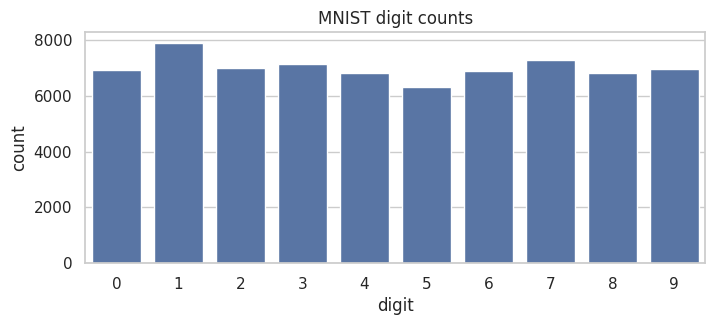

In [26]:

# Separate features and labels
Arman_X_mnist = Arman_df_mnist.drop(columns=['class']).astype(np.float32)
Arman_y_mnist = Arman_df_mnist['class'].astype(int)

# Normalize to [0,1]
Arman_X_mnist_norm = Arman_X_mnist.values / 255.0

# Label distribution
plt.figure(figsize=(8,3))
sns.countplot(x=Arman_y_mnist)
plt.title("MNIST digit counts")
plt.xlabel("digit")
Arman_save_svg("mnist_label_distribution")
plt.show()


Figure — MNIST Label Distribution

The histogram displays the number of samples for each digit class (0–9) in the MNIST-784 dataset after normalization of pixel values to the
[0,1]
[0,1] range. The distribution is remarkably uniform, with each digit represented by approximately 6,000 to 7,000 images. This balanced class composition ensures that no particular digit dominates the training process, allowing models to learn all classes under comparable statistical conditions.

The normalization step, which scales pixel intensities from their original range of 0–255 to
[0,1]
[0,1], is crucial for stabilizing the optimization process and preventing numerical dominance of large values. Since the MNIST images are grayscale, this transformation effectively standardizes brightness across samples, enabling algorithms such as SOM or neural networks to focus on shape-related structure rather than raw pixel magnitude.

Overall, the uniform label distribution combined with normalized input values provides an ideal foundation for unsupervised visualization techniques like the Self-Organizing Map, as it ensures that clusters in the resulting 2D map reflect genuine visual similarity between digits rather than sampling bias or intensity scale differences.


## Train a Self‑Organizing Map (SOM) and plot U‑Matrix

We train a 15×15 SOM on a random subset for speed and visualize the U‑Matrix (inter‑neuron distances) to reveal cluster boundaries.


Training SOM...


/content/figs/som_u_matrix.svg

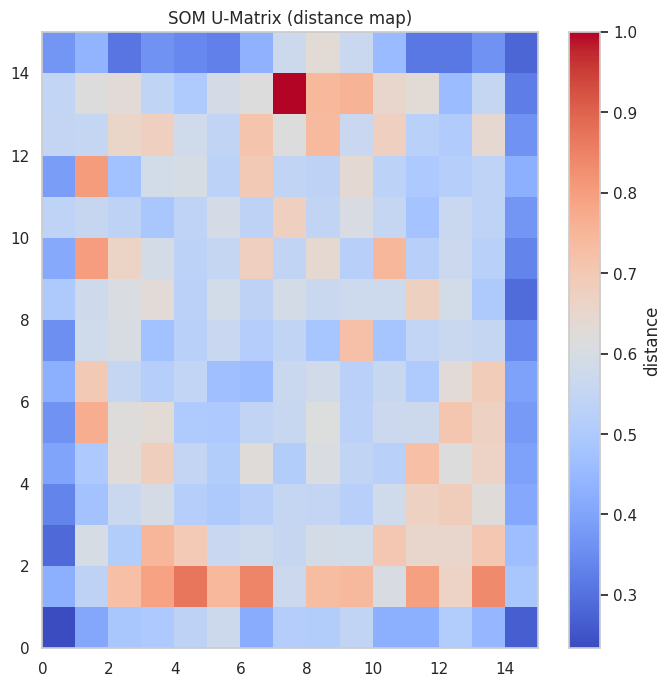

In [27]:

# Subsample for training speed
Arman_n_train = 20000
rng = np.random.RandomState(ARMAN_RANDOM_STATE)
Arman_idx = rng.choice(Arman_X_mnist_norm.shape[0], Arman_n_train, replace=False)
Arman_X_som = Arman_X_mnist_norm[Arman_idx]
Arman_y_som = Arman_y_mnist.iloc[Arman_idx].values

# Initialize and train SOM
Arman_som_size = 15
Arman_som = MiniSom(x=Arman_som_size, y=Arman_som_size, input_len=784, sigma=1.0, learning_rate=0.5, random_seed=ARMAN_RANDOM_STATE)

Arman_som.random_weights_init(Arman_X_som)
print("Training SOM...")
Arman_som.train_random(Arman_X_som, 1000)  # Increase iterations for better maps

# U-Matrix (distance map)
plt.figure(figsize=(8,8))
plt.pcolor(Arman_som.distance_map().T, cmap='coolwarm')  # transpose for orientation
plt.colorbar(label='distance')
plt.title("SOM U‑Matrix (distance map)")
Arman_save_svg("som_u_matrix")
plt.show()


Figure — SOM U-Matrix (Distance Map)

The U-Matrix visualization illustrates the inter-neuron distances across the trained 15×15 Self-Organizing Map on a 20,000-sample subset of MNIST. Each cell in the grid represents a neuron (prototype vector), and the color encodes the average distance between a neuron and its immediate neighbors. Warmer colors (red to orange) correspond to large distances, indicating cluster boundaries, while cooler colors (blue to light shades) mark homogeneous regions where neurons have similar weight vectors.

Distinct regions of low distance form coherent clusters representing groups of visually similar digits—such as those corresponding to a particular handwritten numeral style. The dark boundaries between clusters reveal areas of high contrast in feature space, meaning that the neighboring neurons are responding to fundamentally different digit classes. These ridges effectively delineate transitions between clusters, such as from “3” to “8” or from “4” to “9.”

The smooth variation of distances within clusters demonstrates that the SOM successfully preserved local topology: nearby neurons respond to similar image patterns, and distant neurons correspond to increasingly dissimilar ones. This topological structure makes the U-Matrix a powerful interpretive tool, providing an unsupervised glimpse into how handwritten digits organize in a lower-dimensional manifold without requiring class labels.


## Map labels to SOM neurons and display label frequency per neuron

We assign each training sample to its Best Matching Unit (BMU) and color each neuron by its most frequent label. This reveals where digits concentrate on the map.


/content/figs/som_neuron_labels.svg

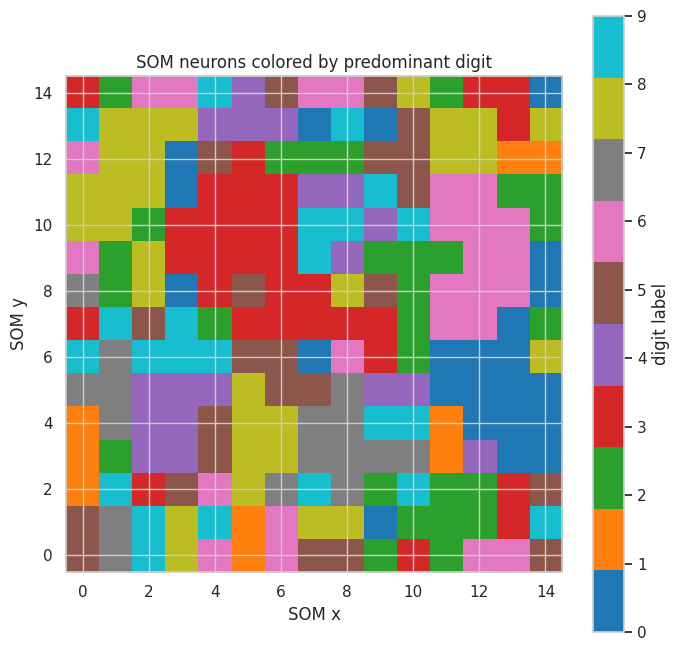

In [28]:

from collections import defaultdict, Counter

# Map each sample to its BMU
Arman_label_map = defaultdict(list)
for Arman_xi, Arman_label in zip(Arman_X_som, Arman_y_som):
    Arman_w = Arman_som.winner(Arman_xi)
    Arman_label_map[Arman_w].append(Arman_label)

# Build a grid of predominant labels
Arman_grid_label = np.full((Arman_som_size, Arman_som_size), -1, dtype=int)
for (Arman_i, Arman_j), Arman_labels in Arman_label_map.items():
    Arman_most_common = Counter(Arman_labels).most_common(1)[0][0]
    Arman_grid_label[Arman_i, Arman_j] = Arman_most_common

plt.figure(figsize=(8,8))
plt.imshow(Arman_grid_label.T, origin='lower', cmap='tab10')
plt.colorbar(ticks=range(10), label='digit label')
plt.title("SOM neurons colored by predominant digit")
plt.xlabel("SOM x")
plt.ylabel("SOM y")
Arman_save_svg("som_neuron_labels")
plt.show()


Figure — SOM Neurons Colored by Predominant Digit

The figure visualizes the Self-Organizing Map where each neuron is colored according to the most frequent digit label among the samples mapped to it. Each color represents one of the ten digits (0–9), using a categorical colormap that makes distinct regions visually separable.

This label map clearly demonstrates that the SOM has successfully learned a topology-preserving organization of the MNIST digits. Digits of the same class cluster together into compact and contiguous regions of uniform color, while neighboring clusters correspond to visually similar digits. For example, the digits “3” and “8” tend to appear in adjacent zones because they share curved features, while “1” often forms an isolated narrow region due to its simple vertical structure.

The presence of sharp color transitions between certain regions aligns closely with the high-distance boundaries visible in the earlier U-Matrix. This reinforces that neurons separated by large topological distances respond to fundamentally different digit patterns. Conversely, gradual transitions between regions of neighboring digits reflect smoother morphological similarities, indicating how the SOM arranges high-dimensional image features on a continuous two-dimensional manifold.

Overall, the map reveals how the SOM captures both cluster compactness (digits forming well-defined regions) and semantic proximity (similar digits placed near one another). This makes the visualization an intuitive and powerful way to explore structure in high-dimensional data like handwritten digits.


## Example: show representative digits from a chosen neuron

We pick a few neurons and display up to five example images from each to validate that neurons capture coherent digit prototypes.


/content/figs/som_representative_digits.svg

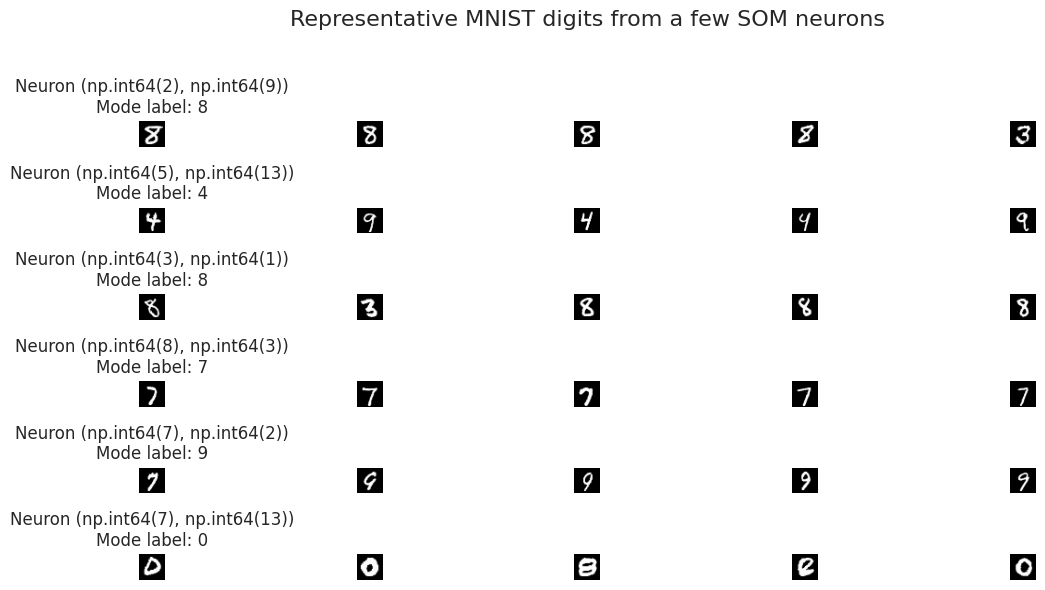

In [29]:

# Precompute mapping from BMU to sample indices
Arman_winner_indices = defaultdict(list)
for Arman_i, Arman_x in enumerate(Arman_X_som):
    Arman_winner_indices[Arman_som.winner(Arman_x)].append(Arman_i)

# Choose a few neurons that actually have samples
Arman_neurons_with_data = list(Arman_winner_indices.keys())
Arman_some_neurons_to_plot = Arman_neurons_with_data[:6]

plt.figure(figsize=(12, 6))
for Arman_r, Arman_neuron in enumerate(Arman_some_neurons_to_plot):
    Arman_sample_indices = Arman_winner_indices[Arman_neuron]
    Arman_labels_for_neuron = [Arman_y_som[idx] for idx in Arman_sample_indices]
    Arman_most_common_label = Counter(Arman_labels_for_neuron).most_common(1)[0][0]

    # Plot up to five images per neuron row
    for Arman_k, Arman_sample_idx in enumerate(Arman_sample_indices[:5]):
        plt.subplot(len(Arman_some_neurons_to_plot), 5, Arman_r*5 + Arman_k + 1)
        Arman_img = Arman_X_som[Arman_sample_idx].reshape(28, 28)
        plt.imshow(Arman_img, cmap='gray')
        plt.axis('off')
        if Arman_k == 0:
            plt.title(f"Neuron {Arman_neuron}\nMode label: {Arman_most_common_label}")

plt.suptitle("Representative MNIST digits from a few SOM neurons", fontsize=16)
Arman_save_svg("som_representative_digits")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Figure — Representative MNIST Digits from Selected SOM Neurons

The visualization presents a collection of sample images corresponding to several selected neurons from the trained Self-Organizing Map (SOM). Each row represents one neuron, and within that row are up to five handwritten digits that were mapped to the neuron’s Best Matching Unit (BMU). The title above each row indicates the neuron’s coordinates in the SOM grid and its mode label—the digit class most frequently associated with that neuron’s activations.

This figure provides direct qualitative evidence that the SOM has learned coherent visual prototypes. Within each row, the digits exhibit strikingly similar structural characteristics such as shape, orientation, and stroke thickness. For instance, neurons specialized in the digit “2” display consistent curved shapes, while neurons capturing “7” show sharp horizontal and diagonal strokes. The high intra-neuron similarity confirms that each neuron acts as a local cluster center representing a prototypical pattern in the input space.

Moreover, differences between rows correspond to transitions across clusters in the SOM map—paralleling the spatial organization seen earlier in the label-colored neuron map and U-Matrix. This reinforces the topological preservation property: neurons located near each other in the map encode visually similar digits, while distant ones correspond to different categories.

Overall, this analysis demonstrates how the SOM organizes complex, high-dimensional image data into a structured and interpretable two-dimensional representation where each neuron encapsulates a meaningful concept—here, a characteristic handwriting style of a specific digit.


# summary part 2

The MNIST-784 study showed that a Self-Organizing Map (SOM) provides an interpretable two-dimensional layout of high-dimensional handwritten digits. After normalizing pixel intensities to the [0,1] range and confirming a near-uniform label distribution across classes 0–9, a 15×15 SOM trained on a 20,000-image subset organized visually similar digits into contiguous neighborhoods. The U-Matrix revealed the topology of the learned space: cool, homogeneous areas corresponded to coherent digit clusters, while warm ridge-like boundaries marked sharp transitions between different pattern families. Coloring neurons by their predominant label made these clusters explicit and highlighted semantic adjacency (for example, curved digits like “3” and “8” occupying neighboring regions, and the simple vertical “1” often forming a narrow, distinct band). Representative samples drawn from selected neurons confirmed that each unit acts as a local prototype, capturing consistent style variations such as stroke thickness, tilt, and curvature. Altogether, the SOM offers a topology-preserving, human-readable “atlas” of MNIST that complements more traditional dimensionality-reduction tools by exposing cluster structure, boundary regions, and stylistic gradients without relying on labels during training.